## Benchmark: Explicit Kronecker Product vs Tensor Contraction

This notebook benchmarks two strategies for computing matrix–vector products of the form
$$
\left( L_{\mathcal S} \otimes L_f \otimes L_u \right)^{-1} \mathbf y,$$
where $L_d$,  $d \in \{\mathcal S, f, u\}$, denote the Cholesky factors of the covariance matrices.

Such operations arise in **multitask Gaussian process (MTGP)** models with
functional covariates and separable covariance structures.
We compare an explicit Kronecker product (`torch.kron`) with an implicit
tensor-contraction approach based on mode-wise operations.

The benchmark is performed on a synthetic example with Rayleigh-type functional
inputs and correlated tasks, and reports execution times as a function of the
number of training functions $n_f$.



In [2]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.decomposition import PCA
import timeit

# --- Optional: TeX in plots (only if your environment supports LaTeX) ---
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

# --- Colors (single source) ---
palette_dict = {
    "Naive Product": "#D0D0D0",
    "Tensor Contraction": "#2F4B7C",
}


In [4]:
# =========================
# Tensor contraction helpers
# =========================
def mode1_product(U, A):
    return torch.tensordot(A, U, dims=([1], [0]))

def mode2_product(U, B):
    temp = torch.tensordot(B, U, dims=([1], [1]))
    return temp.permute(1, 0, 2)

def mode3_product(U, C):
    temp = torch.tensordot(C, U, dims=([1], [2]))
    return temp.permute(1, 2, 0)

def mult_kron_implicit(A, B, C, y_vec):
    Q = A.shape[1]  # tasks
    N = B.shape[1]  # n_f
    S = C.shape[1]  # n_u (time grid)
    U = y_vec.reshape(Q, N, S)
    U1 = mode1_product(U, A)
    U2 = mode2_product(U1, B)
    U3 = mode3_product(U2, C)
    return U3.contiguous().view(-1)

# =========================
# Rayleigh density
# =========================
def drayleigh(x, sigma):
    return (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))
# =========================
# Toy setup
# =========================
nrepTrain = 100
nrepTest  = 1
nrep = nrepTrain + nrepTest

nu = 100
u = np.linspace(0, 1.5, nu)

dimF = 3
dim_task = 2

# Rayleigh inputs
fu = np.zeros((dimF, nrep, nu))
scale_ray = np.linspace(0.05, 1, dimF)

seed = 880
for i in range(dimF):
    fu_iter = np.zeros((nrep, nu))
    for j in range(nrep):
        seed += 1
        rng = np.random.default_rng(seed)
        sigma = rng.uniform(np.min(scale_ray), np.max(scale_ray))
        f = drayleigh(u, sigma)
        amp = rng.uniform(2, 4)
        fu_iter[j, :] = amp * f / np.max(f)
    fu[i, :, :] = fu_iter

# PCA coefficients (per functional dimension)
fu_coeff_pca = []
inertia = 0.999

seed = 8495
for i in range(dimF):
    seed += 1
    rng = np.random.default_rng(seed)
    pca = PCA(n_components=inertia, svd_solver="full")
    pca.fit(fu[i])
    fu_coeff_pca.append(pca.transform(fu[i]))
# =========================
# Temporal kernel (Matern + periodic)
# =========================
sigma2_matern = 1.0
theta_matern = 1.0
sigma2_periodic = 1.0
theta_periodic = 0.5
period = 1.0

class CustomKernel(gpytorch.kernels.Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        matern = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        matern.outputscale = torch.tensor(sigma2_matern)
        matern.base_kernel.lengthscale = torch.tensor(theta_matern)

        periodic = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        periodic.outputscale = torch.tensor(sigma2_periodic)
        periodic.base_kernel.lengthscale = torch.tensor(theta_periodic)
        periodic.base_kernel.period_length = torch.tensor(period)

        self.combined_kernel = matern + periodic

    def forward(self, x1, x2, diag=False, **params):
        return self.combined_kernel(x1, x2, diag=diag, **params)

# Time grid
t = torch.linspace(0, 1.5, nu).unsqueeze(-1)

kernel = CustomKernel()
cov_t = kernel(t, t).evaluate().detach().numpy()

# Task correlation
corr_task = np.array([[1.0, 0.85], [0.85, 1.0]])
Ltask = np.linalg.cholesky(corr_task)

# Functional covariance K_f via PCA coefficients (Matern 5/2 on distances)
par_f = np.repeat(80.0, dimF)
cov_f = np.zeros((nrep, nrep))

for i in range(nrep):
    fi = [fu_coeff_pca[d][i] for d in range(dimF)]
    for j in range(nrep):
        fj = [fu_coeff_pca[d][j] for d in range(dimF)]
        dist2 = 0.0
        for d in range(dimF):
            dist2 += np.sum((fi[d] - fj[d])**2 / par_f[d]**2)
        cov_f[i, j] = (1 + np.sqrt(5 * dist2) + 5 * dist2 / 3) * np.exp(-np.sqrt(5 * dist2))
# =========================
# Sample Y ~ N(0, K_task ⊗ K_f ⊗ K_t) using Cholesky factors
# =========================
Lt = np.linalg.cholesky(cov_t + 1e-5 * np.eye(nu))
Lf = np.linalg.cholesky(cov_f[:nrepTrain, :nrepTrain] + 1e-5 * np.eye(nrepTrain))

def mvrnormCholKron(Ltask, Lf, Lt, seed=48):
    rng = np.random.default_rng(seed)
    S = Ltask.shape[0]
    N = Lf.shape[0]
    T = Lt.shape[0]

    v = rng.normal(size=(S, N, T))
    reshaped = v.reshape(S, N*T)
    correlated = Ltask @ reshaped
    correlated = correlated.reshape(S, N, T)

    correlated = Lf @ correlated @ Lt.T
    return correlated

ysamp = mvrnormCholKron(Ltask, Lf, Lt, seed=48)   # shape: (task, nrepTrain, nu)

# Flatten train vector
train_y_full = torch.tensor(ysamp, dtype=torch.float32)
y_vec_flat = train_y_full.reshape(-1)

# Fixed inverses for A (task) and C (time)
A = torch.tensor(np.linalg.inv(Ltask), dtype=torch.float32)
C = torch.tensor(np.linalg.inv(Lt), dtype=torch.float32)

print("y_vec_flat shape:", y_vec_flat.shape)
print("A shape:", A.shape, "| C shape:", C.shape)


y_vec_flat shape: torch.Size([20000])
A shape: torch.Size([2, 2]) | C shape: torch.Size([100, 100])


In [6]:
# =========================
# Benchmark
# =========================
nrep_list = [5, 25, 50, 100]
n_repeat = 50

time_results = {"Naive Product": [], "Tensor Contraction": []}

for nrepTrain_small in nrep_list:
    # Cholesky + inverse for B_small
    Lf_small = np.linalg.cholesky(cov_f[:nrepTrain_small, :nrepTrain_small] + 1e-5 * np.eye(nrepTrain_small))
    B_small = torch.tensor(np.linalg.inv(Lf_small), dtype=torch.float32)

    # Slice on the FLAT vector
    y_small = y_vec_flat[: (dim_task * nrepTrain_small * nu)]

    def method_naive():
        torch.kron(A, torch.kron(B_small, C)) @ y_small

    def method_tensor():
        mult_kron_implicit(A, B_small, C, y_small)

    t_naive  = timeit.repeat(method_naive,  number=1, repeat=n_repeat)
    t_tensor = timeit.repeat(method_tensor, number=1, repeat=n_repeat)

    time_results["Naive Product"].append(np.mean(t_naive))
    time_results["Tensor Contraction"].append(np.mean(t_tensor))

time_results


{'Naive Product': [0.0002672039601020515,
  0.013557202542433516,
  0.055004948859568685,
  0.21085875105578453],
 'Tensor Contraction': [3.702837857417762e-05,
  9.767714072950184e-05,
  0.00015779849723912776,
  0.00015853784047067165]}

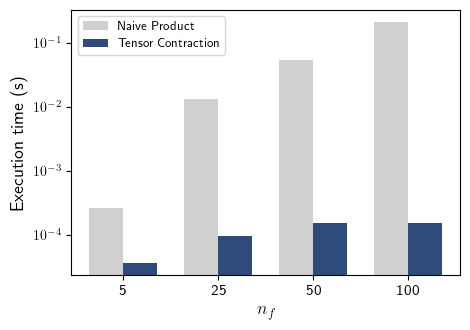

✅ PDF saved to: figures/execution_time_barplot.pdf


In [7]:
nf = np.array(nrep_list)
t_naive  = np.array(time_results["Naive Product"], dtype=float)
t_tensor = np.array(time_results["Tensor Contraction"], dtype=float)

x = np.arange(len(nf))
width = 0.36

fig, ax = plt.subplots(figsize=(4.8, 3.4))

ax.bar(
    x - width/2, t_naive, width,
    label="Naive Product",
    color=palette_dict["Naive Product"]
)
ax.bar(
    x + width/2, t_tensor, width,
    label="Tensor Contraction",
    color=palette_dict["Tensor Contraction"]
)

# Log scale + clean ticks
ax.set_yscale("log")
ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0))
ax.yaxis.set_major_formatter(mticker.LogFormatterMathtext(base=10.0))
ax.yaxis.set_minor_locator(mticker.NullLocator())

ax.set_xlabel(r"$n_f$", fontsize=13, fontweight="bold")
ax.set_ylabel("Execution time (s)", fontsize=13, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels([str(v) for v in nf], fontsize=11)

ax.legend(frameon=True, fontsize=9, loc="upper left")
ax.grid(False)

fig.tight_layout()

# ✅ Recommandé pour GitHub : chemin relatif dans le repo
out_dir = "figures"
import os
os.makedirs(out_dir, exist_ok=True)
output_path = os.path.join(out_dir, "execution_time_barplot.pdf")

plt.savefig(output_path, dpi=400, bbox_inches="tight", format="pdf")
plt.show()

print(f"✅ PDF saved to: {output_path}")
